In [22]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [23]:
base_path = "plant_disease"

contents = os.listdir(base_path)
if len(contents) == 1 and os.path.isdir(os.path.join(base_path, contents[0])):
    base_path = os.path.join(base_path, contents[0])

print("Using dataset folder:", base_path)

Using dataset folder: plant_disease/Dataset


In [24]:
classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print("Classes found:", classes)

Classes found: ['Healthy', 'Rust', 'Powdery']


In [25]:
IMG_SIZE = 64  # Resize images to 64x64

def load_images(base_path, classes, img_size=IMG_SIZE):
    X = []
    y = []
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(base_path, cls)
        if not os.path.exists(cls_folder):
            continue
        for img_file in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_size, img_size))
                img_array = np.array(img)/255.0  # Normalize 0-1
                img_flat = img_array.flatten()    # Flatten for FNN
                X.append(img_flat)
                y.append(idx)
            except Exception as e:
                # Skip corrupted images
                print(f"Skipped {img_path} ({e})")
    return np.array(X), np.array(y)

In [26]:
X, y = load_images(base_path, classes)
print("Total images loaded:", len(X))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Total images loaded: 1532
Shape of X: (1532, 12288)
Shape of y: (1532,)


In [27]:
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Training samples:", X_train.shape[0])
    print("Testing samples:", X_test.shape[0])
else:
    print("No images loaded. Check dataset path and structure.")

Training samples: 1225
Testing samples: 307


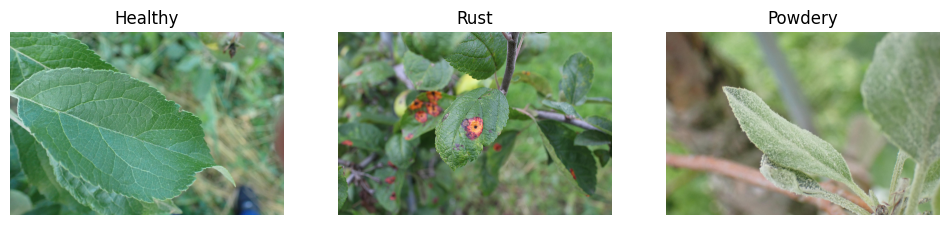

In [50]:
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:6]):  # Show first 6 classes
    img_path = os.path.join(base_path, cls, os.listdir(os.path.join(base_path, cls))[0])
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
num_classes = len(classes)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [31]:
input_dim = X_train.shape[1]  # Flattened image size

model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,456,579 (24.63 MB)

 Trainable params: 6,456,579 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train, y_train_cat,validation_data=(X_test, y_test_cat),epochs=20,batch_size=64)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.3201 - loss: 3.9580 - val_accuracy: 0.3811 - val_loss: 1.0908
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.3232 - loss: 1.7356 - val_accuracy: 0.3713 - val_loss: 1.0409
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.4468 - loss: 1.1187 - val_accuracy: 0.4137 - val_loss: 1.0013
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.4618 - loss: 1.0720 - val_accuracy: 0.6840 - val_loss: 0.8576
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5091 - loss: 0.9715 - val_accuracy: 0.6645 - val_loss: 0.8404
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5189 - loss: 0.9282 - val_accuracy: 0.5603 - val_loss: 0.8751
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.5717 - loss: 0.8632 - val_accuracy: 0.6254 - val_loss: 0.8002
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5905 - loss: 0.8515 - val_accuracy: 0.62

#TEST Without downloaidng datset for quick work  
first download the "plant_diesease_fnn.keras" file and upload it colab vm if working on colab, use the the cell below to load the pre-trained model so that you dont have to download the 1.3GBs worth of dataset and wont need to train it again



In [ ]:
model = load_model("plant_disease_fnn.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("plant_disease_fnn.keras")

In [34]:
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7394 - loss: 0.6502
Test Accuracy: 72.96%


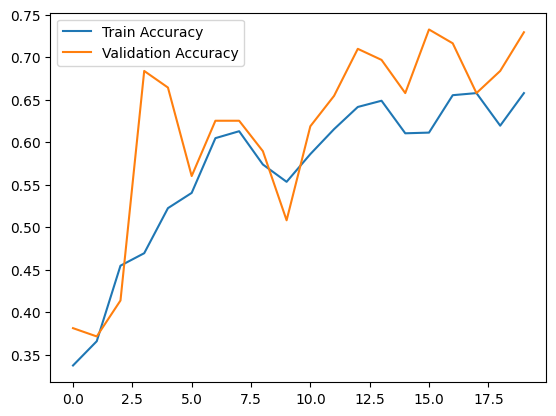

In [35]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

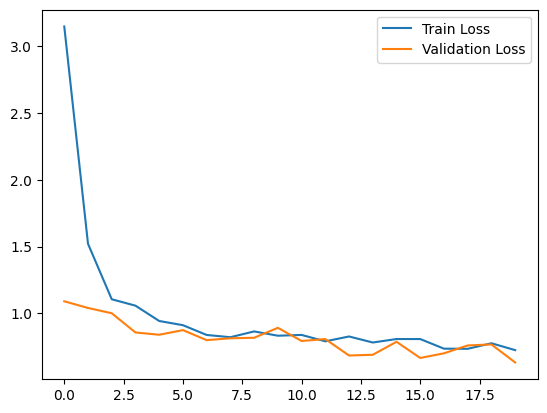

In [36]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


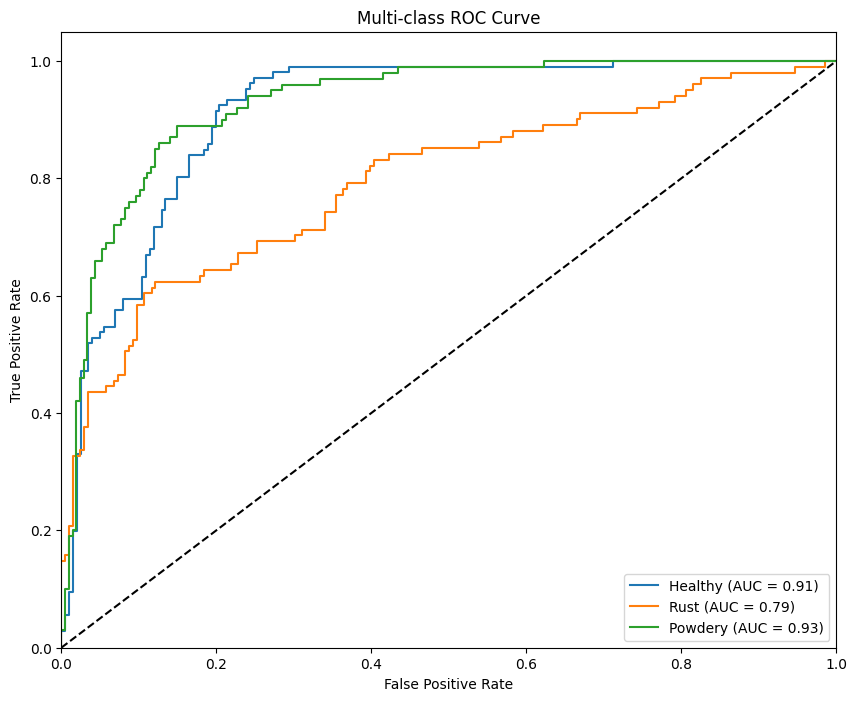

In [39]:
y_pred_prob = model.predict(X_test)

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [42]:
micro_auc = roc_auc_score(y_test_cat, y_pred_prob, average='micro')
print("Micro-average AUC:", micro_auc)

Micro-average AUC: 0.8929272459124233


In [44]:
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


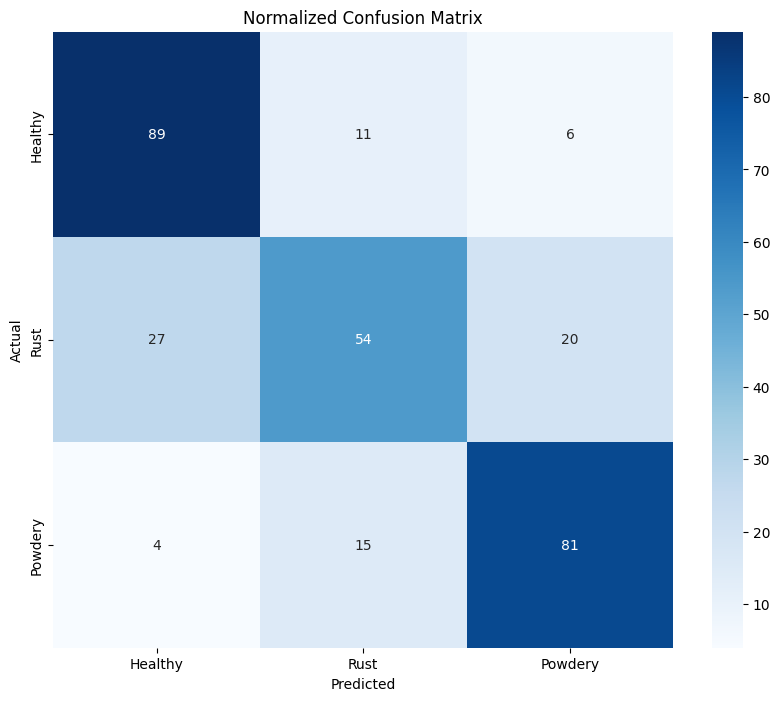

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [58]:
report = classification_report(y_test, y_pred_classes, target_names=classes, digits=2)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.74      0.84      0.79       106
        Rust       0.68      0.53      0.60       101
     Powdery       0.76      0.81      0.78       100

    accuracy                           0.73       307
   macro avg       0.72      0.73      0.72       307
weighted avg       0.72      0.73      0.72       307



In [52]:
model.save("plant_disease_fnn.keras")